In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D
from tensorflow.keras.utils import to_categorical
!pip install -q -U tensorflow-addons

import tensorflow_addons as tfa

from google.colab import drive
from pathlib import Path 
mnt = Path('/content/drive')
drive.mount(str(mnt))

mydrive = Path(mnt) / 'MyDrive'

from sklearn.preprocessing import StandardScaler
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

def plotHist(model):
  plt.plot(model.history.history['loss'])
  plt.plot(model.history.history['val_loss'])
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun May 29 20:16:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
BEG = 0
LIMIT = 300
tr_audio = np.load(mydrive / 'tr_audio_features.npy')[:,BEG:LIMIT]
tst_audio = np.load(mydrive / 'tst_audio_features.npy')[:,BEG:LIMIT]
val_audio = np.load(mydrive / 'val_audio_features.npy')[:,BEG:LIMIT]


tr_lbl_audio = np.load(mydrive / 'tr_lbl_audio.npy')
tst_lbl_audio = np.load(mydrive / 'tst_lbl_audio.npy')
val_lbl_audio = np.load(mydrive / 'val_lbl_audio.npy')

tr_onehot_audio = to_categorical(tr_lbl_audio)
tst_onehot_audio = to_categorical(tst_lbl_audio)
val_onehot_audio = to_categorical(val_lbl_audio)

ss = StandardScaler()
tr_audio = ss.fit_transform(tr_audio)
tst_audio = ss.transform(tst_audio)
val_audio = ss.transform(val_audio)

In [ ]:
tr_audio.shape

(2850, 207)

In [ ]:
tr_audio = np.load(mydrive / 'tr_audio_features.npy')[:,BEG:LIMIT]
tst_audio = np.load(mydrive / 'tst_audio_features.npy')[:,BEG:LIMIT]
val_audio = np.load(mydrive / 'val_audio_features.npy')[:,BEG:LIMIT]

tr_audio1 = ss.transform(tr_audio)
tst_audio1 = ss.transform(tst_audio)
val_audio1 = ss.transform(val_audio)

tr_audio2 = ss.fit_transform(tr_audio)
tst_audio2 = ss.transform(tst_audio)
val_audio2 = ss.transform(val_audio)

# With full librosa features

In [ ]:
NEMBEDD = 193
#%%
def get_clusterer():
    model = tf.keras.models.Sequential()

    model.add(Dense(193, input_shape=(193,), activation = 'relu'))
    #model.add(Dropout(0.))
    model.add(Dense(NEMBEDD, activation = 'relu'))

    return model
clusterer = get_clusterer()
#%%
loss = tfa.losses.TripletSemiHardLoss(margin=2.0)

trainclust = 1
if trainclust:
    clusterer.compile(
        optimizer=tf.keras.optimizers.Adam(2e-3),
        loss=loss)
    
    train = (tr_audio, tr_lbl_audio)
    val = (val_audio, val_lbl_audio)
    
    #%%
    history = clusterer.fit(
        train[0], train[1],
        validation_data=val,
        batch_size=300,
        epochs=100,
        verbose=0, callbacks=[TqdmCallback(verbose=1)])
else:
    clusterer.load_weights('audio_clusterer.h5')
    

tr_out = clusterer(tr_audio)
val_out = clusterer(val_audio)
tst_out = clusterer(tst_audio)

np.save('embeddings_val_audio.npy', val_out)
np.save('embeddings_test_audio.npy', tst_out)
np.save('embeddings_train_audio.npy', tr_out)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
clusterer.save_weights( mydrive /'audio_clusterer.h5' )

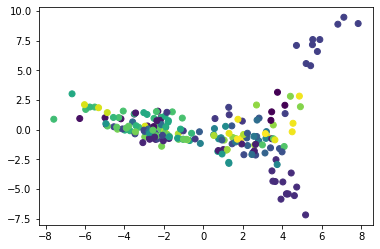

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(tst_out[:200])
labels = tst_lbl_audio[:200]

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=labels)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0.7926315789473685


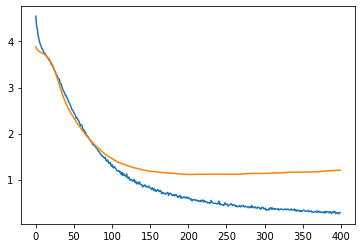

In [ ]:
# for categorical:
train = (tr_out, tr_onehot_audio)
val = (val_out, val_onehot_audio); tstset = tst_out


def get_classifier():
    model = tf.keras.models.Sequential()
    
    model.add(Dense(193, input_shape=(NEMBEDD,), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, input_shape=(193,), activation = 'relu'))
    model.add(Dropout(0.6))
    model.add(Dense(128, input_shape=(193,), activation = 'relu'))
    model.add(Dropout(0.7))
    model.add(Dense(49, activation = 'softmax'))

    return model

classifier = get_classifier()

loss = tf.keras.losses.CategoricalCrossentropy()
trainclass = 1
if trainclass:
    # Compile the model
    classifier.compile(
        optimizer=tf.keras.optimizers.Adam(0.0009),
        loss=loss,
        metrics=['accuracy'])
    

    
    history = classifier.fit(
        train[0], train[1],
        validation_data=val,
        batch_size=3000,
        epochs=400,
        verbose=0, callbacks=[TqdmCallback(verbose=1)])

else:
    classifier.load_weights('features_audio.h5')
#%%
pred = np.argmax(classifier(tstset), axis=1)
print(np.sum(pred==tst_lbl_audio)/pred.shape[0])
plotHist(classifier)

(0.75, 0.82)

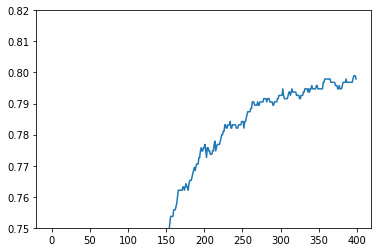

In [ ]:
plt.plot(classifier.history.history['val_accuracy'])
plt.ylim((0.75, 0.82))

In [ ]:
classifier.save_weights( mydrive /'audio_classifier.h5' )

# Without tonnetz (which alone acounts for 69M parameters)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

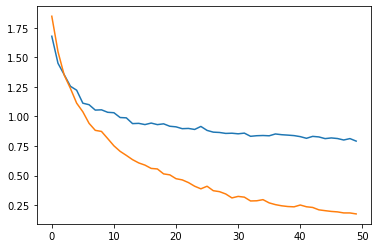

In [ ]:
NEMBEDD = 207
#%%
def get_clusterer():
    model = tf.keras.models.Sequential()

    model.add(Dense(NEMBEDD, input_shape=(NEMBEDD,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(NEMBEDD, activation = 'relu'))

    return model
    
clusterer = get_clusterer()
#%%
loss = tfa.losses.TripletSemiHardLoss(margin=2.0)

trainclust = 1
if trainclust:
    clusterer.compile(
        optimizer=tf.keras.optimizers.Adam(1e-2),
        loss=loss)
    
    train = (tr_audio, tr_lbl_audio)
    val = (val_audio, val_lbl_audio)
    
    #%%
    history = clusterer.fit(
        train[0], train[1],
        validation_data=val,
        batch_size=300,
        epochs=50,
        verbose=0, callbacks=[TqdmCallback(verbose=1)])
else:
    clusterer.load_weights('audio_clusterer.h5')
    


plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')

In [ ]:
tr_out = clusterer(tr_audio)
val_out = clusterer(val_audio)
tst_out = clusterer(tst_audio)

np.save('embeddings_val_audio.npy', val_out)
np.save('embeddings_test_audio.npy', tst_out)
np.save('embeddings_train_audio.npy', tr_out)

If embeddings are well made, we should see
some kind of clustering here

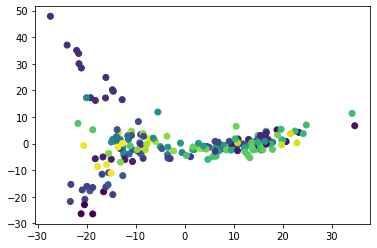

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(tst_out[:200])
labels = tst_lbl_audio[:200]

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=labels)

In [ ]:
tr_out.shape

TensorShape([2850, 187])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0.771578947368421


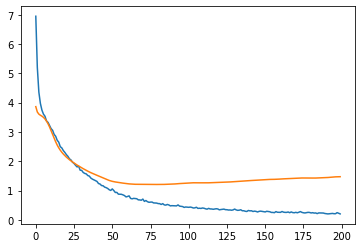

In [ ]:
# for categorical:
train = (tr_out, tr_onehot_audio)
val = (val_out, val_onehot_audio); tstset = tst_out


def get_classifier():
    model = tf.keras.models.Sequential()
    
    model.add(Dense(128, input_shape=(NEMBEDD,), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(49, activation='softmax'))

    return model

classifier = get_classifier()

loss = tf.keras.losses.CategoricalCrossentropy()
trainclass = 1
if trainclass:
    # Compile the model
    classifier.compile(
        optimizer=tf.keras.optimizers.Adam(0.003),
        loss=loss,
        metrics=['accuracy'])
    

    
    history = classifier.fit(
        train[0], train[1],
        validation_data=val,
        batch_size=6000,
        epochs=200,
        verbose=0, callbacks=[TqdmCallback(verbose=1)])

else:
    classifier.load_weights('features_audio.h5')
#%%
pred = np.argmax(classifier(tstset), axis=1)
print(np.sum(pred==tst_lbl_audio)/pred.shape[0])
plotHist(classifier)

(0.1, 0.82)

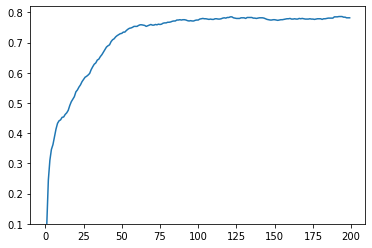

In [ ]:
plt.plot(classifier.history.history['val_accuracy'])
plt.ylim((0.1, 0.82))

In [ ]:
clusterer.save_weights(mydrive / 'audio_clusterer_trimmed.h5')